In [1]:
import pandas as pd
import findspark
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Бібліотеки для PySpark
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import VectorAssembler, StandardScaler as SparkStandardScaler
from pyspark.sql import SparkSession
from pyspark.sql.types import DoubleType, IntegerType
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import PCA
from pyspark.sql import functions as F


In [2]:
# Ініціалізація findspark для використання Spark
findspark.init()

In [3]:
# **Вступ**

# У цьому проекті ми аналізуємо публічний набір даних подій електронної комерції за жовтень та листопад 2019 року.
# Дані містять понад 100 мільйонів записів про взаємодії користувачів з платформою електронної комерції,
# включаючи перегляди товарів, додавання до кошика та покупки.

# **Обґрунтування використання "Великих Даних":**

# - **Обсяг (Volume)**: Дані містять приблизно 110 мільйонів рядків та займають близько 8 ГБ у форматі CSV.
# - **Швидкість (Velocity)**: Дані збираються з високою частотою, що надає детальні уявлення про поведінку користувачів.
# - **Різноманітність (Variety)**: Дані включають різні типи, такі як часові мітки, категоріальні та числові змінні.
# - **Обмеження обробки**: Обробка такого великого обсягу даних на одній машині є неефективною та повільною.
#   Тому для ефективної обробки даних використовується розподілене обчислення з Apache Spark.

# Ці характеристики відповідають трьом "V" (Volume, Velocity, Variety) Великих Даних,
# що обґрунтовує їх класифікацію як Великі Дані.

# **1. Збір та підготовка даних**

# Завантаження даних за жовтень та листопад 2019 року
df_oct = pd.read_csv('2019-Oct.csv')
df_nov = pd.read_csv('2019-Nov.csv')

# Об'єднання наборів даних в один DataFrame
df = pd.concat([df_oct, df_nov], ignore_index=True)

# Звільнення пам'яті від окремих місяців
del df_oct, df_nov

In [4]:
# Початкова інформація про дані
print("Початкова інформація про дані:")
print(df.info())

# Приклад перших 5 рядків
print("\nПриклад даних:")
print(df.head())

# Перевірка на пропущені значення
print("\nПропущені значення у кожному стовпці:")
print(df.isnull().sum())

# Базова статистика
print("\nСтатистичний огляд:")
print(df.describe())

Початкова інформація про дані:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109950743 entries, 0 to 109950742
Data columns (total 9 columns):
 #   Column         Dtype  
---  ------         -----  
 0   event_time     object 
 1   event_type     object 
 2   product_id     int64  
 3   category_id    int64  
 4   category_code  object 
 5   brand          object 
 6   price          float64
 7   user_id        int64  
 8   user_session   object 
dtypes: float64(1), int64(3), object(5)
memory usage: 7.4+ GB
None

Приклад даних:
                event_time event_type  product_id          category_id  \
0  2019-10-01 00:00:00 UTC       view    44600062  2103807459595387724   
1  2019-10-01 00:00:00 UTC       view     3900821  2053013552326770905   
2  2019-10-01 00:00:01 UTC       view    17200506  2053013559792632471   
3  2019-10-01 00:00:01 UTC       view     1307067  2053013558920217191   
4  2019-10-01 00:00:04 UTC       view     1004237  2053013555631882655   

                 

In [5]:
# **Очищення та попередня обробка даних**

# Видалення записів з відсутніми або некоректними значеннями 'price'
df = df.dropna(subset=['price'])      # Видалення записів з відсутніми цінами
df = df[df['price'] > 0]              # Видалення записів з ціною <= 0

# Пояснення: Продукти з відсутніми або некоректними цінами не є корисними для аналізу продажів та доходів.

# Заповнення пропущених значень 'category_code' та 'brand'
df = df.dropna(subset=['brand'])

# Пояснення: Категорія та бренд товару є важливими для аналізу продажів та поведінки користувачів.

# Видалення записів з відсутніми 'user_session'
df.dropna(subset=['user_session'], inplace=True)

# Пояснення: 'user_session' важлива для відстеження поведінки користувачів; відсутні значення ускладнюють аналіз сесій.

# Видалення дублікатів
df = df.drop_duplicates()

# Пояснення: Дублікати можуть спотворити результати аналізу, переоцінюючи певні події.

# Перетворення категоріального 'event_type' у числові значення
df['event_type_encoded'] = df['event_type'].map({'view': 0, 'cart': 1, 'purchase': 2})

# Пояснення: Числове кодування категоріальних змінних необхідне для моделей машинного навчання.

# Перетворення 'event_time' у datetime
df['event_time'] = pd.to_datetime(df['event_time'])

# Додавання часових ознак
df['hour'] = df['event_time'].dt.hour
df['day_of_week'] = df['event_time'].dt.dayofweek
df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >=5 else 0)

# Пояснення: Часові ознаки можуть виявити закономірності в поведінці користувачів, пов'язані з часом дня або днями тижня.

In [6]:
# **Зберігання даних**

# Збереження очищених даних у форматі Parquet для ефективного зберігання та швидшої обробки з Spark.

# Пояснення:
# - Parquet - це колонний формат зберігання, який забезпечує ефективне стиснення даних та схеми кодування.
# - Він оптимізований для продуктивності запитів, особливо для великих наборів даних.
# - Він добре інтегрується з Apache Spark, що дозволяє ефективну розподілену обробку.

df.to_parquet('cleaned_ecommerce_data.parquet', index=False, engine='pyarrow', coerce_timestamps='ms', allow_truncated_timestamps=True)


Кількість подій за типами:
event_type
view        89400144
cart         3560602
purchase     1528041
Name: count, dtype: int64


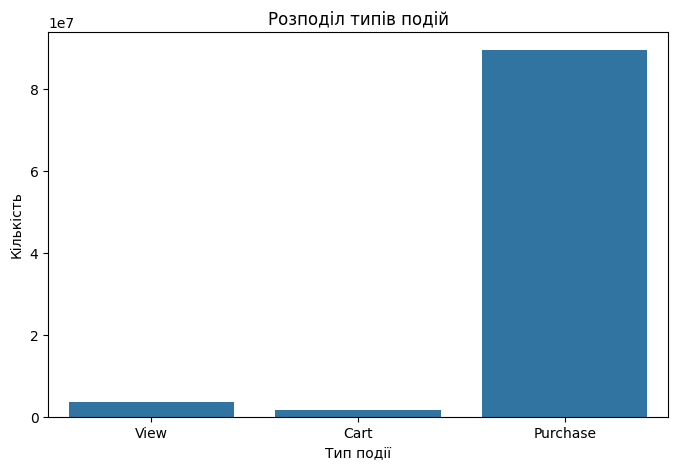

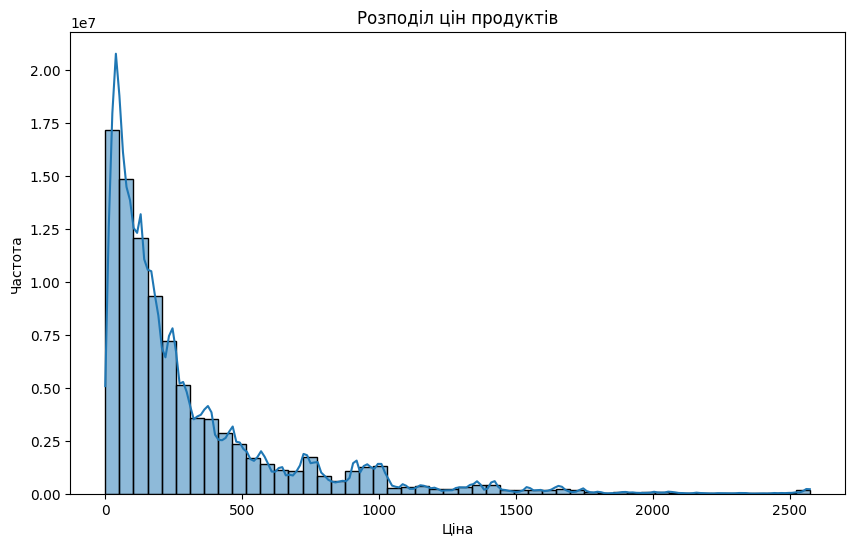

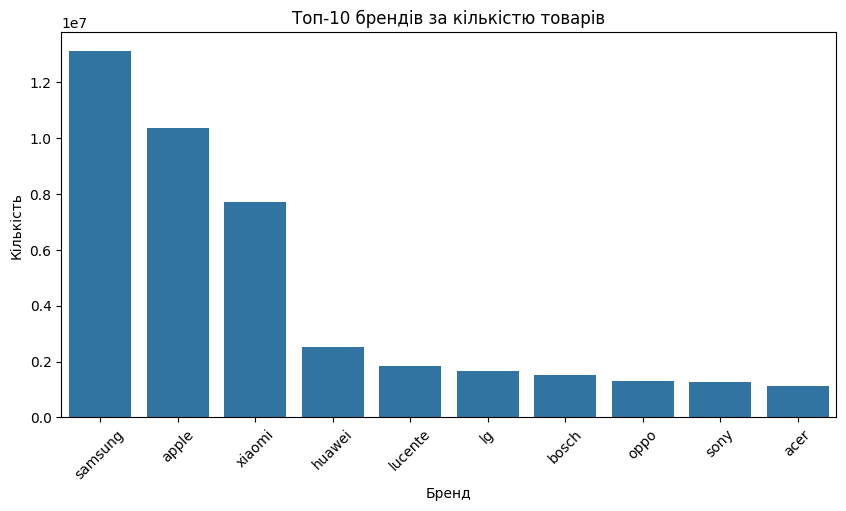

In [7]:
# **2. Аналіз та моделювання**

# **Дослідницький аналіз даних (EDA)**

# Аналіз типів подій
print("\nКількість подій за типами:")
print(df['event_type'].value_counts())

# Візуалізація розподілу типів подій
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='event_type', order=sorted(df['event_type'].unique()))
plt.title('Розподіл типів подій')
plt.xlabel('Тип події')
plt.ylabel('Кількість')
plt.xticks([0, 1, 2], ['View', 'Cart', 'Purchase'])
plt.show()

# Візуалізація розподілу цін
plt.figure(figsize=(10, 6))
sns.histplot(df['price'], bins=50, kde=True)
plt.title('Розподіл цін продуктів')
plt.xlabel('Ціна')
plt.ylabel('Частота')
plt.show()

# Топ-10 брендів за кількістю товарів
top_brands = df['brand'].value_counts().head(10)
plt.figure(figsize=(10, 5))
sns.barplot(x=top_brands.index, y=top_brands.values)
plt.title('Топ-10 брендів за кількістю товарів')
plt.xlabel('Бренд')
plt.ylabel('Кількість')
plt.xticks(rotation=45)
plt.show()

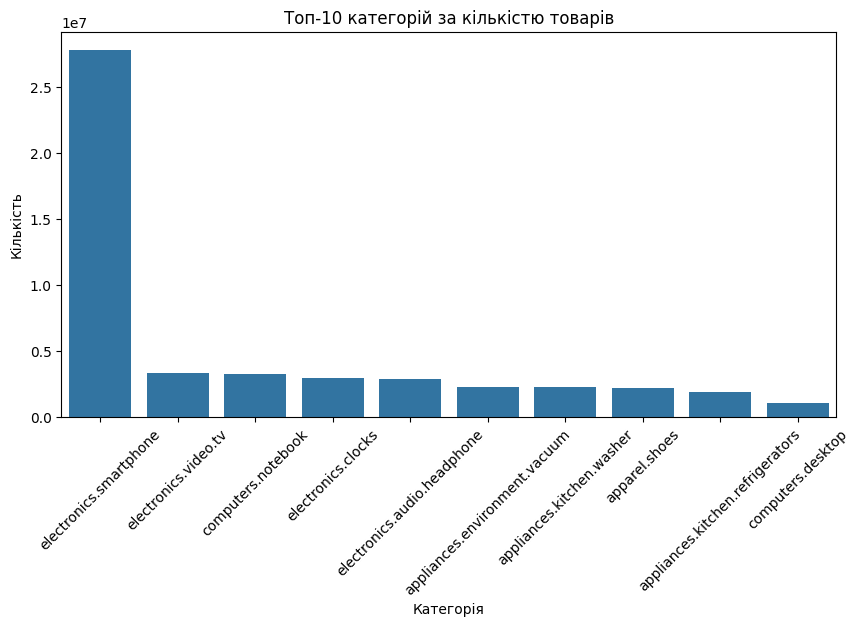

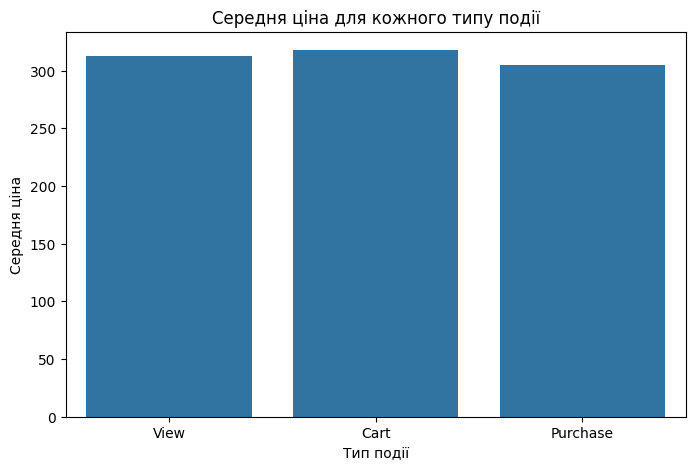

In [8]:
# Топ-10 категорій за кількістю товарів
top_categories = df['category_code'].value_counts().head(10)
plt.figure(figsize=(10, 5))
sns.barplot(x=top_categories.index, y=top_categories.values)
plt.title('Топ-10 категорій за кількістю товарів')
plt.xlabel('Категорія')
plt.ylabel('Кількість')
plt.xticks(rotation=45)
plt.show()

# Середня ціна для кожного типу події
avg_price_per_event = df.groupby('event_type')['price'].mean()
plt.figure(figsize=(8, 5))
sns.barplot(x=avg_price_per_event.index, y=avg_price_per_event.values)
plt.title('Середня ціна для кожного типу події')
plt.xlabel('Тип події')
plt.ylabel('Середня ціна')
plt.xticks([0, 1, 2], ['View', 'Cart', 'Purchase'])
plt.show()

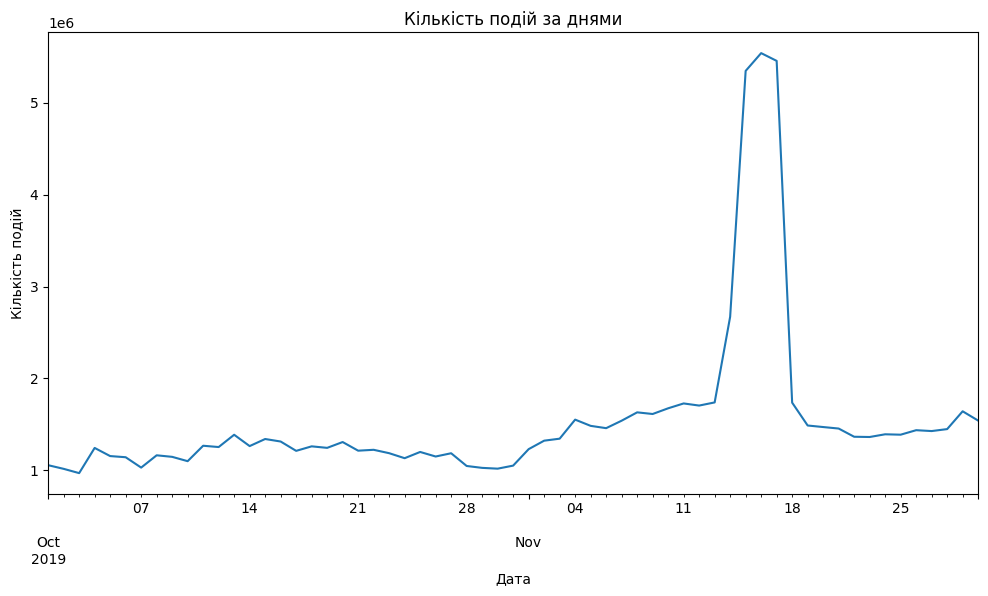

In [9]:
# Щоденна кількость подій
df.set_index('event_time', inplace=True)
daily_counts = df.resample('D').size()
plt.figure(figsize=(12, 6))
daily_counts.plot()
plt.title('Кількість подій за днями')
plt.xlabel('Дата')
plt.ylabel('Кількість подій')
plt.show()

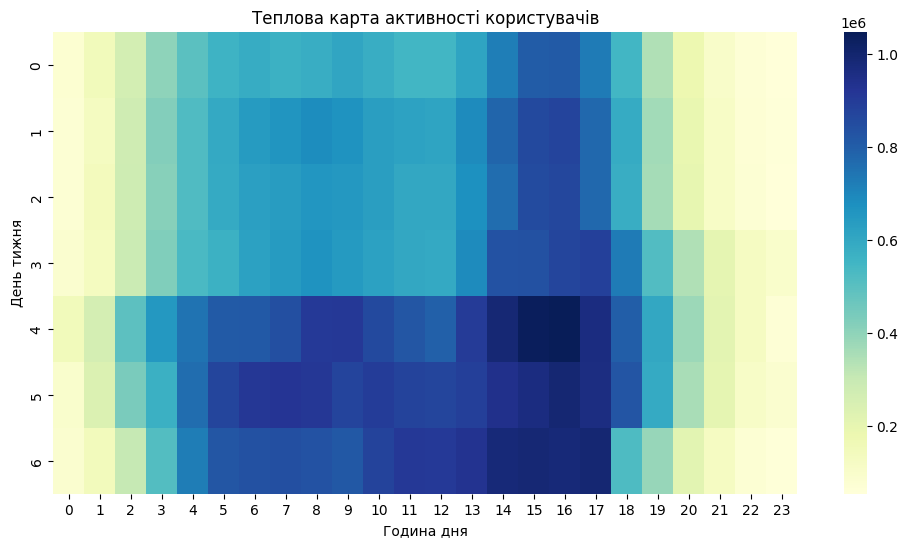

In [10]:
# Теплова карта активності користувачів за днем тижня та годиною
activity = df.groupby(['day_of_week', 'hour']).size().unstack()
plt.figure(figsize=(12, 6))
sns.heatmap(activity, cmap="YlGnBu")
plt.title('Теплова карта активності користувачів')
plt.xlabel('Година дня')
plt.ylabel('День тижня')
plt.show()

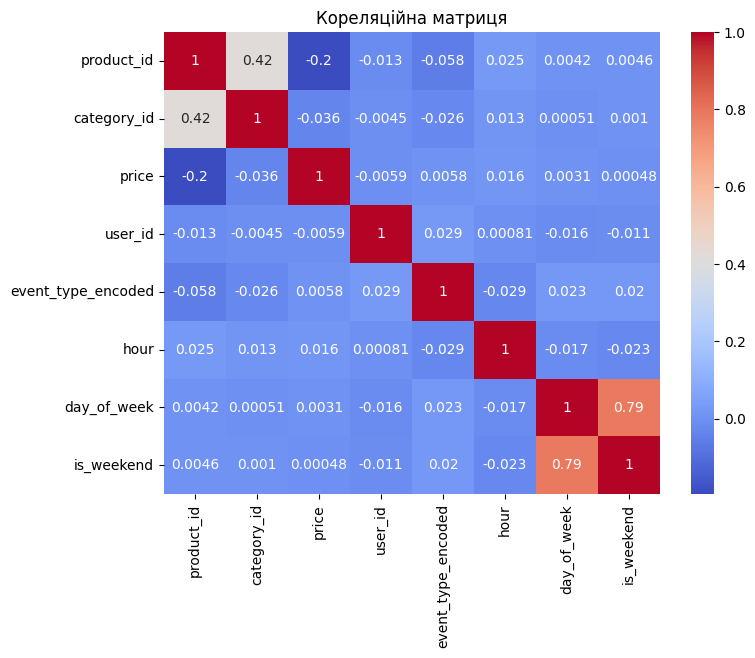

In [11]:
# Вибір числових стовпців для кореляційного аналізу
numeric_df = df.select_dtypes(include=['number'])
plt.figure(figsize=(8, 6))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title('Кореляційна матриця')
plt.show()

In [12]:

# **Вибір та обґрунтування методів аналізу**

# Мета:

# - **Сегментація клієнтів**: Групування користувачів на основі їх поведінки для виявлення шаблонів та налаштування маркетингових стратегій.

# Обґрунтування вибору KMeans кластеризації:

# - **Простота та ефективність**: KMeans є обчислювально ефективним, що важливо для великих наборів даних.
# - **Інтерпретованість**: Алгоритм надає чіткі центри кластерів, що полегшує інтерпретацію сегментів.
# - **Припущення про форму кластерів**: KMeans передбачає сферичні кластери, що прийнятно для цього аналізу.

# Очікувані результати:

# - Виявлення різних шаблонів поведінки користувачів.
# - Надання інформації для персоналізованих рекомендацій, цільової реклами та управління запасами.

# **Оптимізація та налаштування методів аналізу**

# Визначення оптимальної кількості кластерів (k) за допомогою методу "ліктя" та аналізу силуетів.

# **Реалізація методів**

# Ініціалізація Spark Session з налаштуваннями пам'яті
spark = SparkSession.builder \
    .appName("E-commerce User Clustering") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.maxResultSize", "2g") \
    .getOrCreate()
spark.sparkContext.setLogLevel("ERROR")

# Завантаження очищених даних у Spark DataFrame
spark_df = spark.read.parquet('cleaned_ecommerce_data.parquet')

# Кодування брендів за допомогою StringIndexer
brand_indexer = StringIndexer(inputCol='brand', outputCol='brand_index', handleInvalid='keep')
spark_df = brand_indexer.fit(spark_df).transform(spark_df)

# Перетворення типів даних
spark_df = spark_df.withColumn("event_type_encoded", spark_df["event_type_encoded"].cast(IntegerType()))
spark_df = spark_df.withColumn("price", spark_df["price"].cast(DoubleType()))
spark_df = spark_df.withColumn("brand_index", spark_df["brand_index"].cast(DoubleType()))
spark_df = spark_df.withColumn("is_weekend", spark_df["is_weekend"].cast(IntegerType()))
spark_df = spark_df.withColumn("hour", spark_df["hour"].cast(IntegerType()))
spark_df = spark_df.withColumn("day_of_week", spark_df["day_of_week"].cast(IntegerType()))

24/11/21 23:48:59 WARN Utils: Your hostname, MacBook-Pro-Nazarii.local resolves to a loopback address: 127.0.0.1; using 192.168.1.101 instead (on interface en0)
24/11/21 23:48:59 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/21 23:49:00 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [13]:
# **Агрегація даних за user_id**

# Створення тимчасової в'ю для виконання SQL-запитів
spark_df.createOrReplaceTempView("ecommerce_data")

# Агрегація потрібних ознак
user_features = spark.sql("""
SELECT
    user_id,
    COUNT(*) AS activity_frequency,
    SUM(CASE WHEN event_type = 'purchase' THEN 1 ELSE 0 END) AS purchase_count,
    SUM(CASE WHEN event_type = 'cart' THEN 1 ELSE 0 END) AS cart_count,
    SUM(CASE WHEN event_type = 'view' THEN 1 ELSE 0 END) AS view_count,
    SUM(CASE WHEN event_type = 'purchase' THEN price ELSE 0 END) AS total_spend,
    AVG(is_weekend) AS weekend_ratio,
    AVG(brand_index) AS avg_brand_index,
    AVG(hour) AS avg_hour,
    AVG(day_of_week) AS avg_day_of_week
FROM
    ecommerce_data
GROUP BY
    user_id
""")

In [14]:
# **Масштабування avg_brand_index**

# Отримуємо мінімальне та максимальне значення avg_brand_index
min_max_values = user_features.agg(
    F.min('avg_brand_index').alias('min_brand_index'),
    F.max('avg_brand_index').alias('max_brand_index')
).collect()[0]

min_brand_index = min_max_values['min_brand_index']
max_brand_index = min_max_values['max_brand_index']

# Додаємо стовпець з нормалізованим avg_brand_index
user_features = user_features.withColumn(
    'normalized_brand_index',
    (user_features['avg_brand_index'] - min_brand_index) / (max_brand_index - min_brand_index)
)

# Віднімаємо нормалізоване значення від 1, щоб отримати показник популярності бренду
user_features = user_features.withColumn('popularity_brand_score', 1 - user_features['normalized_brand_index'])

# Додаємо логарифмічне перетворення ознак
user_features = user_features.withColumn('log_activity_frequency', F.log1p('activity_frequency'))
user_features = user_features.withColumn('log_total_spend', F.log1p('total_spend'))


In [15]:
feature_cols = [
    'log_activity_frequency',
    'purchase_count',
    'cart_count',
    'view_count',
    'log_total_spend',
    'weekend_ratio',
    'popularity_brand_score',  # Використовуємо популярність бренду
    'avg_hour',
    'avg_day_of_week',
]

# **Перетворення всіх обраних стовпців у числовий тип**

for col_name in feature_cols:
    user_features = user_features.withColumn(col_name, user_features[col_name].cast(DoubleType()))

In [16]:
# **Підготовка даних для кластеризації**

# Нормалізація ознак
assembler = VectorAssembler(inputCols=feature_cols, outputCol='features_raw')
scaler = SparkStandardScaler(inputCol='features_raw', outputCol='features', withMean=True, withStd=True)

assembled_data = assembler.transform(user_features)
scaler_model = scaler.fit(assembled_data)
scaled_data = scaler_model.transform(assembled_data)

# **Перегляд перших 5 рядків з ознаками**

scaled_data.select('features').show(5, truncate=False)

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|features                                                                                                                                                                              |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[-0.5608510656510561,-0.17410415216973693,-0.2537295198885561,-0.3282230626943912,-0.37569391936518576,-0.7654080857648246,-1.3714583506748728,-1.9985421242621237,-1.239761002851841]|
|[2.5999349317730043,0.4009504203054488,0.4655745234942325,3.7094672214843016,2.6650675064957845,0.33705547256485546,-0.5242672776582781,0.14170918691809703,0.06979856490256932]      |
|[1.2429646307019073,-0.17410415216973693,-0.2537295198885561,0.38562273340

In [17]:
# Визначення оптимального k за допомогою методу "ліктя" та аналізу силуетів
cost = []
silhouette_scores = []
k_values = range(2, 10)  # Можна змінити діапазон за потреби

for k in k_values:
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol('features')
    model = kmeans.fit(scaled_data)
    predictions = model.transform(scaled_data)
    
    # Обчислення WSSSE (Within Set Sum of Squared Errors)
    wssse = model.summary.trainingCost
    cost.append(wssse)
    
    # Обчислення коефіцієнта силуету
    evaluator = ClusteringEvaluator(featuresCol='features', predictionCol='prediction', metricName='silhouette', distanceMeasure='squaredEuclidean')
    silhouette = evaluator.evaluate(predictions)
    silhouette_scores.append(silhouette)
    
    print(f"Для k = {k}, WSSSE = {wssse}, Коефіцієнт силуету = {silhouette}")

Для k = 2, WSSSE = 37005116.892543435, Коефіцієнт силуету = 0.624127582578905


Для k = 3, WSSSE = 30318126.880823784, Коефіцієнт силуету = 0.4009581527092302


Для k = 4, WSSSE = 27309403.495395035, Коефіцієнт силуету = 0.44687436118311274


Для k = 5, WSSSE = 24770087.890027724, Коефіцієнт силуету = 0.4123417674751408


Для k = 6, WSSSE = 22316683.160935678, Коефіцієнт силуету = 0.4788638584706616


Для k = 7, WSSSE = 21295372.867542554, Коефіцієнт силуету = 0.38376607263544615


Для k = 8, WSSSE = 19263301.754757497, Коефіцієнт силуету = 0.3586957201422991


Для k = 9, WSSSE = 17420010.29276919, Коефіцієнт силуету = 0.37965465470331844


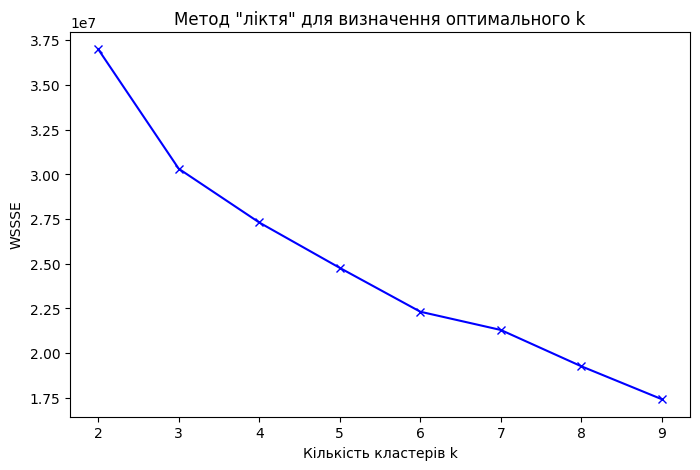

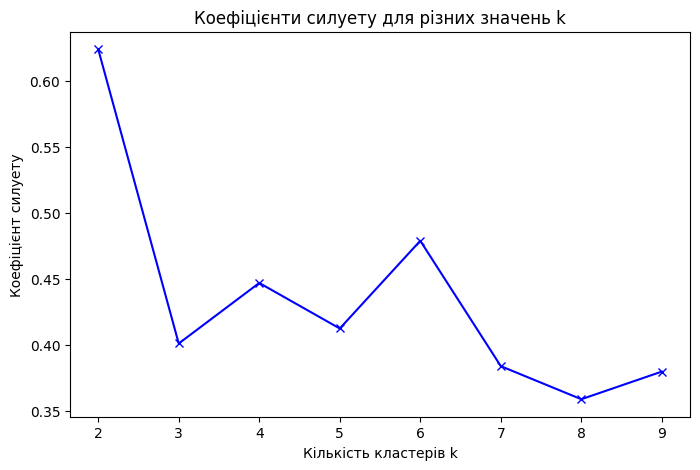

In [18]:
# Візуалізація WSSSE (метод "ліктя")
plt.figure(figsize=(8, 5))
plt.plot(k_values, cost, 'bx-')
plt.xlabel('Кількість кластерів k')
plt.ylabel('WSSSE')
plt.title('Метод "ліктя" для визначення оптимального k')
plt.show()

# Візуалізація коефіцієнтів силуету
plt.figure(figsize=(8, 5))
plt.plot(k_values, silhouette_scores, 'bx-')
plt.xlabel('Кількість кластерів k')
plt.ylabel('Коефіцієнт силуету')
plt.title('Коефіцієнти силуету для різних значень k')
plt.show()

In [19]:
# Вибір оптимального k на основі максимального коефіцієнта силуету
optimal_k = k_values[silhouette_scores.index(max(silhouette_scores))]
print(f"Оптимальна кількість кластерів: {optimal_k}")

Оптимальна кількість кластерів: 2


In [20]:
# Навчання моделі KMeans з оптимальним k

kmeans = KMeans().setK(optimal_k).setSeed(1).setFeaturesCol('features')
model = kmeans.fit(scaled_data)
predictions = model.transform(scaled_data)


In [21]:
# **3. Візуалізація та презентація результатів**

# Аналіз результатів кластеризації

# Підрахунок кількості записів у кожному кластері
cluster_counts = predictions.groupBy('prediction').count().orderBy('prediction')
cluster_counts.show()

# Огляд центрів кластерів
centers = model.clusterCenters()
print("Координати центрів кластерів:")
for idx, center in enumerate(centers):
    print(f"Кластер {idx}: {center}")

+----------+-------+
|prediction|  count|
+----------+-------+
|         0| 691763|
|         1|4355256|
+----------+-------+

Координати центрів кластерів:
Кластер 0: [ 1.31229496  1.05962788  1.20501065  1.0598022   2.23997328  0.14631082
  0.13480564 -0.02052015  0.15351046]
Кластер 1: [-0.208434   -0.16830246 -0.19139385 -0.16833015 -0.35577869 -0.02323879
 -0.02141141  0.00325925 -0.02438232]


In [22]:
# Конвертація центрів кластерів у DataFrame для інтерпретації
centers_df = pd.DataFrame(centers, columns=feature_cols)
centers_df['cluster'] = centers_df.index

# Інтерпретація кластерів
for idx, row in centers_df.iterrows():
    print(f"\nКластер {idx}:")
    print(f"- Середнє логарифмічне значення активності {row['log_activity_frequency']}")
    print(f"- Середня кількість покупок {row['purchase_count']}")
    print(f"- Середня кількість доданих речей в корзину {row['cart_count']}")
    print(f"- Середня кількість переглядів {row['view_count']}")
    print(f"- Середнє логарифмічне значення витрачених грошей {row['log_total_spend']}")
    print(f"- Середнє значення між вихідним і буднім днем {row['weekend_ratio']}")
    print(f"- Середній індекс бренду: {row['popularity_brand_score']}")
    print(f"- Середнє значення години активності {row['avg_hour']}")
    print(f"- Середнє значення дня тижня активності {row['avg_day_of_week']}")


Кластер 0:
- Середнє логарифмічне значення активності 1.3122949551516212
- Середня кількість покупок 1.059627876940278
- Середня кількість доданих речей в корзину 1.2050106450205211
- Середня кількість переглядів 1.059802202895767
- Середнє логарифмічне значення витрачених грошей 2.239973279098234
- Середнє значення між вихідним і буднім днем 0.14631082028328155
- Середній індекс бренду: 0.13480564332084083
- Середнє значення години активності -0.02052015272689859
- Середнє значення дня тижня активності 0.15351045995854348

Кластер 1:
- Середнє логарифмічне значення активності -0.2084339952688869
- Середня кількість покупок -0.16830246205031843
- Середня кількість доданих речей в корзину -0.19139384945112245
- Середня кількість переглядів -0.16833015053298034
- Середнє логарифмічне значення витрачених грошей -0.3557786898652873
- Середнє значення між вихідним і буднім днем -0.023238791479657444
- Середній індекс бренду: -0.02141140504420549
- Середнє значення години активності 0.00325

In [23]:
# Аналіз середніх значень ознак для кожного кластера
cluster_summary_spark = predictions.groupBy('prediction').agg(
    F.mean('log_activity_frequency').alias('avg_log_activity_frequency'),
    F.mean('purchase_count').alias('avg_purchase_count'),
    F.mean('cart_count').alias('avg_cart_count'),
    F.mean('view_count').alias('avg_view_count'),
    F.mean('log_total_spend').alias('avg_log_total_spend'),
    F.mean('weekend_ratio').alias('avg_weekend_ratio'),
    F.mean('popularity_brand_score').alias('avg_popularity_brand_score'),
    F.mean('avg_hour').alias('avg_hour'),
    F.mean('avg_day_of_week').alias('avg_day_of_week')
)
cluster_summary_spark.show()

+----------+--------------------------+--------------------+-----------------+------------------+-------------------+-------------------+--------------------------+------------------+------------------+
|prediction|avg_log_activity_frequency|  avg_purchase_count|   avg_cart_count|    avg_view_count|avg_log_total_spend|  avg_weekend_ratio|avg_popularity_brand_score|          avg_hour|   avg_day_of_week|
+----------+--------------------------+--------------------+-----------------+------------------+-------------------+-------------------+--------------------------+------------------+------------------+
|         1|        1.8155679589137135|0.010088729571809327|0.173315185146407|10.167481084923596|0.03902091960104378|0.28799654734913605|        0.9708049674748725|10.937975578734958| 3.039794613281138|
|         0|        3.6679773734774384|  2.1453908347222965|4.055970035980531| 65.22199221409645|  5.125050444681782|0.35378809990641763|        0.9794012914438818|10.831801763752948|3.338

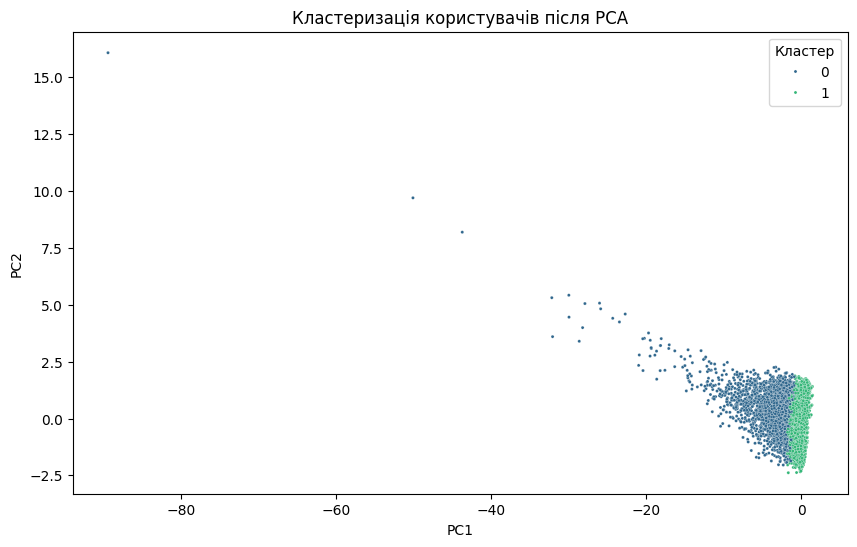

In [24]:
# Візуалізація кластерів за двома головними компонентами

# Виконання PCA для зменшення розмірності
pca = PCA(k=2, inputCol="features", outputCol="pcaFeatures")
pca_model = pca.fit(predictions)
pca_result = pca_model.transform(predictions)

# Обмеження кількості даних для візуалізації (наприклад, 10 000 записів)
pca_sample = pca_result.select("pcaFeatures", "prediction").limit(10000)

# Конвертація в Pandas DataFrame для візуалізації
pca_pd = pca_sample.toPandas()
pca_pd[['pc1', 'pc2']] = pd.DataFrame(pca_pd['pcaFeatures'].tolist(), index=pca_pd.index)

# Візуалізація
plt.figure(figsize=(10, 6))
sns.scatterplot(x='pc1', y='pc2', hue='prediction', data=pca_pd, palette='viridis', s=5)
plt.title('Кластеризація користувачів після PCA')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(title='Кластер')
plt.show()

In [25]:
# Порівняння продуктивності: PySpark vs Pandas

# Вимірювання часу обробки в PySpark
start_time = time.time()
popular_products_spark = spark_df.groupBy('category_code').count().orderBy('count', ascending=False)
popular_products_spark.show(10)
end_time = time.time()
print(f"Час обробки в PySpark: {end_time - start_time:.2f} секунд")

# Вимірювання часу обробки в Pandas
start_time = time.time()
popular_products_pandas = df['category_code'].value_counts().head(10)
print(popular_products_pandas)
end_time = time.time()
print(f"Час обробки в Pandas: {end_time - start_time:.2f} секунд")

+--------------------+--------+
|       category_code|   count|
+--------------------+--------+
|electronics.smart...|27779379|
|                NULL|25935912|
|electronics.video.tv| 3301837|
|  computers.notebook| 3293799|
|  electronics.clocks| 2941937|
|electronics.audio...| 2892801|
|appliances.enviro...| 2285392|
|appliances.kitche...| 2245408|
|       apparel.shoes| 2191344|
|appliances.kitche...| 1859583|
+--------------------+--------+
only showing top 10 rows

Час обробки в PySpark: 2.30 секунд
category_code
electronics.smartphone              27779379
electronics.video.tv                 3301837
computers.notebook                   3293799
electronics.clocks                   2941937
electronics.audio.headphone          2892801
appliances.environment.vacuum        2285392
appliances.kitchen.washer            2245408
apparel.shoes                        2191344
appliances.kitchen.refrigerators     1859583
computers.desktop                    1050643
Name: count, dtype: int64
Ч

In [26]:
# **Висновки та потенційні застосування**

# Кластерний аналіз виявив різні сегменти користувачів та продуктів у даних електронної комерції.

# **Потенційні застосування:**

# - **Маркетингові стратегії**:

#   - Налаштування промоакцій та реклами для конкретних сегментів користувачів.
#   - Виявлення потенційних клієнтів з високою цінністю для цільових кампаній.

# - **Рекомендації продуктів**:

#   - Покращення системи рекомендацій, пропонуючи продукти, популярні в кластері користувача.
#   - Збільшення можливостей крос-продажів через розуміння переваг користувачів.

# - **Управління запасами**:

#   - Оптимізація рівнів запасів на основі популярності продуктів у різних кластерах.
#   - Прогнозування тенденцій попиту через аналіз поведінки кластерів з часом.

# - **Покращення користувацького досвіду**:

#   - Персоналізація інтерфейсу сайту/додатку відповідно до характеристик кластеру користувача.
#   - Впровадження функцій, які залучають користувачів у пікові періоди активності.

# **Майбутня робота:**

# - Інтеграція більш просунутих моделей машинного навчання для прогнозування поведінки користувачів.
# - Дослідження обробки даних у режимі реального часу для надання миттєвих інсайтів та рекомендацій.

# **Архітектура системи**

# **Огляд:**

# - **Джерело даних**: Сирі CSV-файли, що містять дані подій електронної комерції.
# - **Зберігання даних**: Очищені дані зберігаються у форматі Parquet для ефективного доступу.
# - **Фреймворк обробки**: Apache Spark використовується для розподіленої обробки та аналізу.
# - **Інструменти аналізу**: PySpark MLlib для задач машинного навчання; Pandas та Seaborn для візуалізації.

# **Обґрунтування вибору технологій:**

# - **Apache Spark**:

#   - **Масштабованість**: Може ефективно обробляти великі набори даних через розподілені обчислення.
#   - **Швидкість**: Обчислення в пам'яті підвищує швидкість обробки.
#   - **Універсальність**: Підтримує різні задачі обробки даних, включаючи SQL-запити, потокові дані, машинне навчання та графові обчислення.

# - **Формат Parquet**:

#   - **Колонне зберігання**: Покращує продуктивність читання для вибраних стовпців.
#   - **Стиснення**: Зменшує місце для зберігання та пропускну здатність вводу/виводу.

# - **PySpark MLlib**:

#   - **Інтеграція з Spark**: Дозволяє безшовне використання алгоритмів машинного навчання на великих наборах даних.
#   - **Продуктивність**: Оптимізований для розподілених обчислювальних середовищ.

# Така архітектура дозволяє ефективно працювати з Великими Даними, забезпечуючи масштабований та продуктивний аналіз, який неможливо здійснити на одній машині.

In [27]:
# Зупинка Spark Session
spark.stop()